# Data Prep

The purpose of this notebook is to use functions from Feature-Engineering.ipynb and data cleaning functions from Data-Preprocessing.ipynb. At the end we will split the data into 70% training, 15% validation, and 15% testing dataframes that will be used for model building.

In [234]:
#Import libraries
import pandas as pd
import numpy as np
import os
import warnings
import time
from sklearn.model_selection import GroupShuffleSplit

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)


#Import Data
games = pd.read_csv("games.csv")
players = pd.read_csv("players.csv")
plays = pd.read_csv("plays.csv")
tackles = pd.read_csv("tackles.csv")

tracking = pd.read_csv("tracking_week_2.csv")
tracking = tracking.merge(plays, how = 'left', on =['gameId', 'playId'])

#Extract a subset of data
# tracking = tracking[(tracking["gameId"]==2022092513) & (tracking["playId"]==320) & (tracking["frameId"]==51)].reset_index()
tracking = tracking[(tracking["gameId"]==2022091807) & (tracking["playId"]==56) & (tracking["frameId"]==13)].reset_index()
tracking

,index,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,passLength,penaltyYards,prePenaltyPlayResult,playResult,playNullifiedByPenalty,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,687132,2022091807,56,38577.0,Bobby Wagner,13,2022-09-18 16:06:06.099999,45.0,LA,left,75.680000,25.87,4.78,2.12,0.48,231.88,213.70,NaN,48374,Olamide Zaccheaus,(15:00) (Shotgun) M.Mariota pass short middle ...,1,1,10,ATL,LA,ATL,25,15:00,0,0,C,9.0,NaN,10,10,N,85,SHOTGUN,6.0,0.497866,0.777446,0.222554,-0.009405,0.009405,1.298699,0.479512,NaN,NaN,NaN,NaN
1,687152,2022091807,56,39975.0,Cordarrelle Patterson,13,2022-09-18 16:06:06.099999,84.0,ATL,left,85.340000,37.79,1.83,1.01,0.18,260.45,265.58,NaN,48374,Olamide Zaccheaus,(15:00) (Shotgun) M.Mariota pass short middle ...,1,1,10,ATL,LA,ATL,25,15:00,0,0,C,9.0,NaN,10,10,N,85,SHOTGUN,6.0,0.497866,0.777446,0.222554,-0.009405,0.009405,1.298699,0.479512,NaN,NaN,NaN,NaN
2,687172,2022091807,56,41232.0,Jake Matthews,13,2022-09-18 16:06:06.099999,70.0,ATL,left,88.840000,19.76,2.93,0.79,0.30,306.93,268.02,NaN,48374,Olamide Zaccheaus,(15:00) (Shotgun) M.Mariota pass short middle ...,1,1,10,ATL,LA,ATL,25,15:00,0,0,C,9.0,NaN,10,10,N,85,SHOTGUN,6.0,0.497866,0.777446,0.222554,-0.009405,0.009405,1.298699,0.479512,NaN,NaN,NaN,NaN
3,687192,2022091807,56,41239.0,Aaron Donald,13,2022-09-18 16:06:06.099999,99.0,LA,left,89.130000,23.12,2.20,0.34,0.22,290.00,260.00,NaN,48374,Olamide Zaccheaus,(15:00) (Shotgun) M.Mariota pass short middle ...,1,1,10,ATL,LA,ATL,25,15:00,0,0,C,9.0,NaN,10,10,N,85,SHOTGUN,6.0,0.497866,0.777446,0.222554,-0.009405,0.009405,1.298699,0.479512,NaN,NaN,NaN,NaN
4,687212,2022091807,56,42345.0,Marcus Mariota,13,2022-09-18 16:06:06.099999,1.0,ATL,left,91.380000,23.47,1.58,1.15,0.15,259.76,272.88,NaN,48374,Olamide Zaccheaus,(15:00) (Shotgun) M.Mariota pass short middle ...,1,1,10,ATL,LA,ATL,25,15:00,0,0,C,9.0,NaN,10,10,N,85,SHOTGUN,6.0,0.497866,0.777446,0.222554,-0.009405,0.009405,1.298699,0.479512,NaN,NaN,NaN,NaN
5,687232,2022091807,56,42816.0,Troy Hill,13,2022-09-18 16:06:06.099999,2.0,LA,left,61.270000,18.32,6.96,2.01,0.70,304.38,272.73,NaN,48374,Olamide Zaccheaus,(15:00) (Shotgun) M.Mariota pass short middle ...,1,1,10,ATL,LA,ATL,25,15:00,0,0,C,9.0,NaN,10,10,N,85,SHOTGUN,6.0,0.497866,0.777446,0.222554,-0.009405,0.009405,1.298699,0.479512,NaN,NaN,NaN,NaN
6,687252,2022091807,56,43294.0,Jalen Ramsey,13,2022-09-18 16:06:06.099999,5.0,LA,left,66.220000,43.28,5.00,3.76,0.50,194.47,208.34,NaN,48374,Olamide Zaccheaus,(15:00) (Shotgun) M.Mariota pass short middle ...,1,1,10,ATL,LA,ATL,25,15:00,0,0,C,9.0,NaN,10,10,N,85,SHOTGUN,6.0,0.497866,0.777446,0.222554,-0.009405,0.009405,1.298699,0.479512,NaN,NaN,NaN,NaN
7,687272,2022091807,56,43298.0,Leonard Floyd,13,2022-09-18 16:06:06.099999,54.0,LA,left,80.370000,35.48,4.64,1.13,0.46,218.70,232.09,NaN,48374,Olamide Zaccheaus,(15:00) (Shotgun) M.Mariota pass short middle ...,1,1,10,ATL,LA,ATL,25,15:00,0,0,C,9.0,NaN,10,10,N,85,SHOTGUN,6.0,0.497866,0.777446,0.222554,-0.009405,0.009405,1.298699,0.479512,NaN,NaN,NaN,NaN
8,687292,2022091807,56,43335.0,A'Shawn Robinson,13,2022-09-18 16:06:06.099999,94.0,LA,left,87.650000,28.53,2.80,0.35,0.29,218.58,277.55,NaN,48374,Olamide Zaccheaus,(15:00) (Shotgun) M.Mariota pass short middle ...,1,1,10,ATL,LA,ATL,25,15:00,0,0,C,9.0,NaN,10,10,N,85,SHOTGUN,6.0,0.497866,0.777446,0.222554,-0.009405,0.009405,1.298699,0.479512,NaN,NaN,NaN,NaN
9,687312,2022091807,56,45355.0,Anthony Firkser,13,2022-09-18 16:06:06.099999,86.0,ATL,left,64.390000,47.67,5.65,4.67,0.57,231.41,251.31,NaN,48374,Olami

# Voronoi Tessellations to be implemented

In [235]:
def voronoi_tessellations(tracking, plays):
    from scipy.spatial import Voronoi
    from shapely.geometry import Point, Polygon
    
    # Did above - don't need in testing file
    # tracking = tracking.merge(plays[['gameId', 'playId', 'ballCarrierId', 'defensiveTeam']], how = 'inner', on = ['gameId', 'playId']) 
    
    def process_frame(df_frame):
        # Sample DataFrame with columns: nflId, x, y, ballCarrierId
        data = {
            'gameId': df_frame['gameId'].values,
            'playId': df_frame['playId'].values,
            'frameId': df_frame['frameId'].values,
            'nflId': df_frame['nflId'].values,
            'x': df_frame['x'].values,
            'y': df_frame['y'].values,
            'ballCarrierId': df_frame['ballCarrierId'].iloc[0],
            'club': df_frame['club'].values,
            'defensiveTeam': df_frame['defensiveTeam'].values
        }
    
        # Convert frame data to a Dataframe
        df = pd.DataFrame(data)
    
        # Ghost records to add at corners of the field to help with infinite polygons
        new_records = {
            'gameId': 0,
            'playId': 0,
            'frameId': 0,
            'nflId': [1, 2, 3, 4],
            'x': [10.0, 10.0, 110.0, 110.0],
            'y': [0.0, 53.3, 0.0, 53.3],
            'ballCarrierId': df['ballCarrierId'].iloc[0],
            'club': 'ghost',
            'defensiveTeam': 'none'
        }
    
        # Convert the new records to a DataFrame
        new_df = pd.DataFrame(new_records)
    
        # Append the new DataFrame to the original DataFrame
        df = pd.concat([df, new_df], ignore_index=True).dropna(subset=['nflId'])
    
        # Exclude the ball carrier from the player points
        player_points_without_ball_carrier = df[df['nflId'] != df['ballCarrierId']][['x', 'y']].values
    
        # Compute Voronoi diagram for all non-ball carrier players
        vor = Voronoi(player_points_without_ball_carrier)
    
        # Create a new column for the Voronoi region index for each non-ball carrier player
        df['voronoi_region'] = -1  # Initialize with -1
    
        # Iterate through non-ball carrier players and Voronoi regions
        for idx, (player, region_idx) in enumerate(zip(df[df['nflId'] != df['ballCarrierId']].itertuples(), vor.point_region)):
            # Skip empty or incomplete regions
            if region_idx != -1:
                df.at[player.Index, 'voronoi_region'] = region_idx
    
        # Calculate the Voronoi region for the ball carrier
        ball_carrier_point = df[df['nflId'] == df['ballCarrierId']][['x', 'y']].values[0]
        ball_carrier_region = -1  # Initialize with -1
    
        # Create a dictionary to map nflId to voronoi_region
        nflid_to_region = dict(zip(df['nflId'], df['voronoi_region']))
    
        # Iterate through Voronoi regions to find the one containing the ball carrier
        for idx, region in enumerate(vor.regions):
            if -1 not in region:
                region_points = vor.vertices[region]
                
                # Reset point list to create next standardized polygon
                region_points_standardized = []
                
                # Extract x and y coordinates from vertexes and limit values to dimensions of field
                for vertex in region_points:
                    vertex_point = Point(vertex)
                    vertex_x, vertex_y = vertex_point.x, vertex_point.y
                    vertex_x = 110 if vertex_x > 110 else (10 if vertex_x < 10 else vertex_x)
                    vertex_y = 53.3 if vertex_y > 53.3 else (0 if vertex_y < 0 else vertex_y)
                    vertex_point_standardized = Point(vertex_x, vertex_y)                
                    region_points_standardized.append(vertex_point_standardized)
                    
                # Recreate polygon using standardized region points   
                region_polygon = Polygon(region_points_standardized)
                ball_carrier_point = Point(ball_carrier_point)
                
                # Initialize min and max distances for each iteration
                min_dist_from_bc = float('inf')
                max_dist_from_bc = 0
                
                # Loop through nflId to identify who belongs to the current region
                for nflid, region_value in nflid_to_region.items():
                    if region_value == idx:
    
                        # Loop over all the points in the current region and identify minimum and maximum
                        for vertex in region_points_standardized:
                            vertex_point = Point(vertex)
                            distance = ball_carrier_point.distance(vertex_point)
                            min_dist_from_bc = min(min_dist_from_bc, distance)
                            max_dist_from_bc = max(max_dist_from_bc, distance)
                            
                        # Assign voronoi features for each player
                        df.loc[df['nflId'] == nflid, 'voronoi_min_dist_from_bc'] = min_dist_from_bc
                        df.loc[df['nflId'] == nflid, 'voronoi_max_dist_from_bc'] = max_dist_from_bc
                        df.loc[df['nflId'] == nflid, 'voronoi_area'] = region_polygon.area
                        df.loc[df['nflId'] == nflid, ['voronoi_minx','voronoi_miny','voronoi_maxx','voronoi_maxy']] = region_polygon.bounds
    
                # Identify if ball carrier is within this region
                if ball_carrier_point.within(region_polygon):
                    ball_carrier_region = idx
                    
        # Create columns for horizontal yards to the endzone from the minimum and maximum x coordinates in the region
        df['voronoi_close_adj'] = df.apply(lambda x: 110 - x['voronoi_maxx'], axis = 1)
        df['voronoi_far_adj'] = df.apply(lambda x: 110 - x['voronoi_minx'], axis = 1)
    
        # Create a new column to indicate (1/0) if the ball carrier is present in that Voronoi region
        df['bc_in_voronoi'] = (df['voronoi_region'] == ball_carrier_region).astype(int)
        
        # Create a new column for previously calculated voronoi features for ball carrier and apply to all rows
        # df['bc_voronoi_area'] = df.apply(lambda x: x['voronoi_area'] if x['bc_in_voronoi'] else 0, axis = 1)
        # df['bc_voronoi_close_adj'] = df.apply(lambda x: x['voronoi_close_adj'] if x['bc_in_voronoi'] else 0, axis = 1)
        # df['bc_voronoi_far_adj'] = df.apply(lambda x: x['voronoi_far_adj'] if x['bc_in_voronoi'] else 0, axis = 1)
        
        bc_voronoi_area = df.apply(lambda x: x['voronoi_area'] if x['bc_in_voronoi'] else 0, axis = 1)
        bc_voronoi_close_adj = df.apply(lambda x: x['voronoi_close_adj'] if x['bc_in_voronoi'] else 0, axis = 1)
        bc_voronoi_far_adj = df.apply(lambda x: x['voronoi_far_adj'] if x['bc_in_voronoi'] else 0, axis = 1)
        
        # Apply ball carrier values to rest of rows
        df[['bc_voronoi_area','bc_voronoi_close_adj','bc_voronoi_far_adj']] = bc_voronoi_area.max(), bc_voronoi_close_adj.max(), bc_voronoi_far_adj.max()
        
        # Make min distance to ball carrier 0 if ball carrier is in region
        df['voronoi_min_dist_from_bc'] = df.apply(lambda x: 0 if x['bc_in_voronoi'] else x['voronoi_min_dist_from_bc'], axis = 1)

        # Only keep defensive observations TODO: REMOVED as we omit this later
        # df = df[df['club'] == df['defensiveTeam']]
    
        # Return the DataFrame with relevant columns
        return df
    
    # Assuming you have a DataFrame called 'tracking_data' with columns gameId, playId, and frameId
    unique_game_play_frame = tracking[['gameId', 'playId', 'frameId']].drop_duplicates()
    
    # Create an empty DataFrame to store results
    result_df = pd.DataFrame()
    
    # Iterate over unique combinations of gameId, playId, frameId
    for _, row in unique_game_play_frame.iterrows():
        game_id, play_id, frame_id = row['gameId'], row['playId'], row['frameId']
        
        # Filter the original tracking data for the current combination
        current_frame_data = tracking[(tracking['gameId'] == game_id) & (tracking['playId'] == play_id) & (tracking['frameId'] == frame_id)]
        
        # Process the frame and append the results to the result DataFrame
        result_df = pd.concat([result_df, process_frame(current_frame_data)], ignore_index=True)
    
    return result_df

voronoi = voronoi_tessellations(tracking, plays)

voronoi

,gameId,playId,frameId,nflId,x,y,ballCarrierId,club,defensiveTeam,voronoi_region,voronoi_min_dist_from_bc,voronoi_max_dist_from_bc,voronoi_area,voronoi_minx,voronoi_miny,voronoi_maxx,voronoi_maxy,voronoi_close_adj,voronoi_far_adj,bc_in_voronoi,bc_voronoi_area,bc_voronoi_close_adj,bc_voronoi_far_adj
0,2022091807,56,13,38577.0,75.68,25.87,48374,LA,LA,25,0.000000,10.113982,39.925440,70.241683,24.628533,80.321267,34.339423,29.678733,39.758317,1,39.92544,29.678733,39.758317
1,2022091807,56,13,39975.0,85.34,37.79,48374,ATL,LA,5,11.996119,30.137609,272.728735,77.789504,32.707360,102.887611,53.300000,7.112389,32.210496,0,39.92544,29.678733,39.758317
2,2022091807,56,13,41232.0,88.84,19.76,48374,ATL,LA,14,13.649286,29.895356,181.132384,85.071087,2.373992,102.473876,21.500898,7.526124,24.928913,0,39.92544,29.678733,39.758317
3,2022091807,56,13,41239.0,89.13,23.12,48374,LA,LA,16,12.384863,15.903415,7.232925,87.201785,21.303651,90.564765,24.643400,19.435235,22.798215,0,39.92544,29.678733,39.758317
4,2022091807,56,13,42345.0,91.38,23.47,48374,ATL,LA,9,15.231090,34.833526,250.251059,90.267665,13.150244,110.000000,36.332823,0.000000,19.732335,0,39.92544,29.678733,39.758317
5,2022091807,56,13,42816.0,61.27,18.32,48374,LA,LA,7,9.624818,44.468248,474.559979,30.803028,0.000000,68.927103,22.682663,41.072897,79.196972,0,39.92544,29.678733,39.758317
6,2022091807,56,13,43294.0,66.22,43.28,48374,LA,LA,18,10.113379,34.615065,295.147841,42.197069,31.524522,78.815571,51.106969,31.184429,67.802931,0,39.92544,29.678733,39.758317
7,2022091807,56,13,43298.0,80.37,35.48,48374,LA,LA,22,6.605187,22.315415,126.197061,70.516449,29.571060,84.680523,47.533491,25.319477,39.483551,0,39.92544,29.678733,39.758317
8,2022091807,56,13,43335.0,87.65,28.53,48374,LA,LA,21,9.999234,30.176459,60.910458,83.282658,27.309913,102.956362,37.249301,7.043638,26.717342,0,39.92544,29.678733,39.758317
9,2022091807,56,13,45355.0,64.39,47.67,48374,ATL,LA,6,25.991082,40.986867,273.944190,35.749785,35.842309,85.395875,53.300000,24.604125,74.250215,0,39.92544,29.678733,39.758317


# This code is just to graph as a sanity check

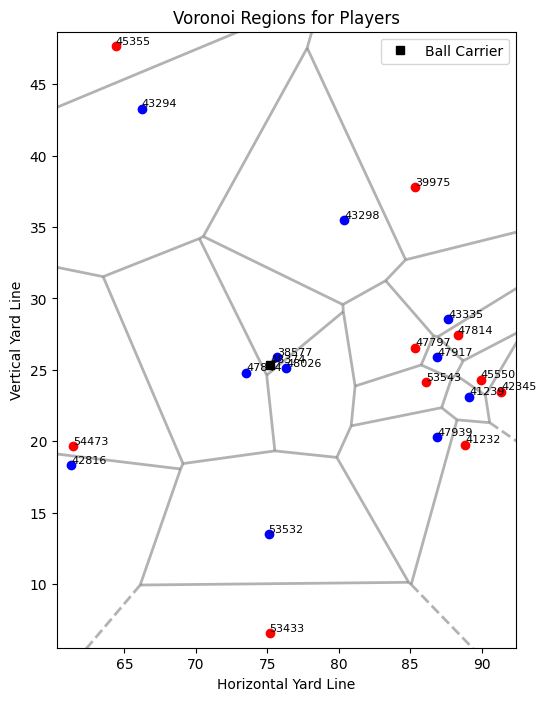

In [236]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import pandas as pd

# Assuming df is your DataFrame with the tracking data
# Filter out the football row (where nflId is NaN)
player_data = tracking.dropna(subset=['nflId'])

# Extract player points, club information, and ball carrier ID
player_points = player_data[['x', 'y']].values
player_nfl_ids = player_data['nflId'].values
player_clubs = player_data['club'].values
ball_carrier_id = player_data['ballCarrierId'].iloc[0]  # Replace with the actual ball carrier ID from your data

# Exclude the ball carrier from the player points
player_points_without_ball_carrier = player_points[player_data['nflId'] != ball_carrier_id]
nfl_ids_without_ball_carrier = player_nfl_ids[player_data['nflId'] != ball_carrier_id]

# Compute Voronoi diagram for all players except the ball carrier
vor = Voronoi(player_points_without_ball_carrier)

# Plot Voronoi regions
fig, ax = plt.subplots(figsize=(8, 8))

# Plot Voronoi diagram for all players except the ball carrier
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray', line_width=2, line_alpha=0.6, point_size=5)

# Plot the original points with different colors for each team and add labels
for x, y, nfl_id, club in zip(player_points_without_ball_carrier[:, 0],
                              player_points_without_ball_carrier[:, 1],
                              nfl_ids_without_ball_carrier,
                              player_clubs[player_data['nflId'] != ball_carrier_id]):
    col = ['blue' if club == player_data['club'].iloc[0] else 'red']
    # ax.plot(x, y, 'o', label=club, color = col[0])
    ax.plot(x, y, 'o', color = col[0])
    ax.text(x, y, str(int(nfl_id)), fontsize=8, ha='left', va='bottom')

# Plot the ball carrier's position
ball_carrier_point = player_data[player_data['nflId'] == ball_carrier_id][['x', 'y']].values
ax.plot(ball_carrier_point[:, 0], ball_carrier_point[:, 1], 's', label='Ball Carrier', color='black')
ax.text(ball_carrier_point[:,0], ball_carrier_point[:, 1], str(int(ball_carrier_id)), fontsize = 8, ha='left', va='bottom')
ax.set_xlabel("Horizontal Yard Line")
ax.set_ylabel("Vertical Yard Line")
ax.set_title("Voronoi Regions for Players")
# Set plot limits
ax.set_xlim(vor.min_bound[0] - 1, vor.max_bound[0] + 1)
ax.set_ylim(vor.min_bound[1] - 1, vor.max_bound[1] + 1)
# ax.set_xlim(0, 120)
# ax.set_ylim(0, 55)
ax.set_aspect('equal', adjustable='box')

# Add legend
ax.legend()
plt.show()

# Extract x and y coordinates of Voronoi regions
voronoi_regions = [vor.vertices[region] for region in vor.regions if len(region) > 0]

# Display the x and y coordinates for each Voronoi region
# for idx, region in enumerate(voronoi_regions):
#     print(f"Voronoi Region {idx + 1} coordinates:")
#     print(region)
#     print("=" * 30)


# UPDATED WITH NEW FEATURES AND TESTING

In [204]:
starttime = time.time()

plays = pd.read_csv("plays.csv")
tackles = pd.read_csv("tackles.csv")
tracking = pd.read_csv("tracking_week_3.csv")
tracking = tracking.merge(plays, how = 'left', on =['gameId', 'playId'])
#Extract a play and frame
tracking_data = tracking[(tracking["gameId"]==2022092513) & (tracking["playId"]==320) & (tracking["frameId"]==51)].reset_index()

import pandas as pd
from scipy.spatial import Voronoi
from shapely.geometry import Point, Polygon

def process_frame(df_frame):
    # Sample DataFrame with columns: nflId, x, y, ballCarrierId
    data = {
        'gameId': df_frame['gameId'].values,
        'playId': df_frame['playId'].values,
        'frameId': df_frame['frameId'].values,
        'nflId': df_frame['nflId'].values,
        'x': df_frame['x'].values,
        'y': df_frame['y'].values,
        'ballCarrierId': df_frame['ballCarrierId'].iloc[0],
        'club': df_frame['club'].values,
        'defensiveTeam': df_frame['defensiveTeam'].values
    }

    df = pd.DataFrame(data)

    # Ghost records to add at corners of the field to help with infinite polygons
    new_records = {
        'gameId': 0,
        'playId': 0,
        'frameId': 0,
        'nflId': [1, 2, 3, 4],
        'x': [10.0, 10.0, 110.0, 110.0],
        'y': [0.0, 53.3, 0.0, 53.3],
        'ballCarrierId': df['ballCarrierId'].iloc[0],
        'club': 'ghost',
        'defensiveTeam': 'none'
    }

    # Convert the new records to a DataFrame
    new_df = pd.DataFrame(new_records)

    # Append the new DataFrame to the original DataFrame
    df = pd.concat([df, new_df], ignore_index=True).dropna(subset=['nflId'])

    # Exclude the ball carrier from the player points
    player_points_without_ball_carrier = df[df['nflId'] != df['ballCarrierId']][['x', 'y']].values

    # Compute Voronoi diagram for all non-ball carrier players
    vor = Voronoi(player_points_without_ball_carrier)

    # Create a new column for the Voronoi region index for each non-ball carrier player
    df['voronoi_region'] = -1  # Initialize with -1

    # Iterate through non-ball carrier players and Voronoi regions
    for idx, (player, region_idx) in enumerate(zip(df[df['nflId'] != df['ballCarrierId']].itertuples(), vor.point_region)):
        # Skip empty or incomplete regions
        if region_idx != -1:
            df.at[player.Index, 'voronoi_region'] = region_idx

    # Calculate the Voronoi region for the ball carrier
    ball_carrier_point = df[df['nflId'] == df['ballCarrierId']][['x', 'y']].values[0]
    ball_carrier_region = -1  # Initialize with -1

    # Create a dictionary to map nflId to voronoi_region
    nflid_to_region = dict(zip(df['nflId'], df['voronoi_region']))

    # Iterate through Voronoi regions to find the one containing the ball carrier
    for idx, region in enumerate(vor.regions):
        if -1 not in region:
            region_points = vor.vertices[region]
            
            # Reset point list to create next polygon
            region_points_standardized = []
            
            # Cap x and y coordinates to field dimension and recreate polygons
            for vertex in region_points:
                vertex_point = Point(vertex)
                # print(f'Vertex point: {vertex_point} - vertext x point {vertex_point.x} - vertex y point {vertex_point.y}')
                vertex_x, vertex_y = vertex_point.x, vertex_point.y
                vertex_x = 110 if vertex_x > 110 else (0 if vertex_x < 0 else vertex_x)
                vertex_y = 53.3 if vertex_y > 53.3 else (0 if vertex_y < 0 else vertex_y)
                # print(f'AFTER Vertex point: {Point(vertex_x, vertex_y)} - vertext x point {vertex_x} - vertex y point {vertex_y}')
                vertex_point_standardized = Point(vertex_x, vertex_y)                
                # print(f'Vertex point: {vertex_point} - Polygon points: {region_points}')
                region_points_standardized.append(vertex_point_standardized)
                
            # point_polygon = Polygon(point_list)
            old_polygon = Polygon(region_points)
            region_polygon = Polygon(region_points_standardized)
            # print(f'Point polygon: {Polygon(region_points_standardized)} \nORIGINAL points: {Polygon(region_points)}')
            ball_carrier_point = Point(ball_carrier_point)
            # print(f'Region points: {region_points}... minx, miny, maxx, maxy: {region_polygon.bounds}')
            # Initialize min and max distances for each iteration
            min_dist_from_bc = float('inf')
            max_dist_from_bc = 0
            
            # print(f'Polygon area for Voronoi Region {region} is {region_polygon.area}')

            # Loop through nflId to identify who belongs to the current region
            for nflid, region_value in nflid_to_region.items():
                if region_value == idx and nflid in ():

                    # Loop over all the points in the current region and identify minimum and maximum
                    for vertex in region_points_standardized:
                        vertex_point = Point(vertex)
                        distance = ball_carrier_point.distance(vertex_point)
                        min_dist_from_bc = min(min_dist_from_bc, distance)
                        max_dist_from_bc = max(max_dist_from_bc, distance)
                        
                    # Assign minimum and maximum distance from the ball carrier for each player
                    df.loc[df['nflId'] == nflid, 'voronoi_min_dist_from_bc'] = min_dist_from_bc
                    df.loc[df['nflId'] == nflid, 'voronoi_max_dist_from_bc'] = max_dist_from_bc
                    df.loc[df['nflId'] == nflid, 'voronoi_area'] = region_polygon.area
                    df.loc[df['nflId'] == nflid, ['voronoi_minx','voronoi_miny','voronoi_maxx','voronoi_maxy']] = region_polygon.bounds
                    # print(f'Polygon area for Voronoi Region {region} and nflId {nflid} is {region_polygon.area}')

            if ball_carrier_point.within(region_polygon):
                ball_carrier_region = idx
                # break # REMOVE BREAK TO FINISH GETTING DISTANCES
                
    # Create columns for horizontal yards from endzone for the points in region that are closest and furthest to endzone
    df['voronoi_close_adj'] = df.apply(lambda x: 110 - x['voronoi_maxx'], axis = 1)
    df['voronoi_far_adj'] = df.apply(lambda x: 110 - x['voronoi_minx'], axis = 1)

    # Create a new column to indicate (1/0) if the ball carrier is present in that Voronoi region
    df['bc_in_voronoi'] = (df['voronoi_region'] == ball_carrier_region).astype(int)
    
    # Create a new column for ball carrier region's area, min and max horizontal yards from endzone TODO: SHOULD ALL rows be assigned this value??
    df['bc_voronoi_area'] = df.apply(lambda x: x['voronoi_area'] if x['bc_in_voronoi'] else 0, axis = 1)
    df['bc_voronoi_close_adj'] = df.apply(lambda x: x['voronoi_close_adj'] if x['bc_in_voronoi'] else 0, axis = 1)
    df['bc_voronoi_far_adj'] = df.apply(lambda x: x['voronoi_far_adj'] if x['bc_in_voronoi'] else 0, axis = 1)

    # Only keep defensive observations
    df = df[df['club'] == df['defensiveTeam']]

    # Return the DataFrame with the new columns
    # return df[['gameId', 'playId', 'frameId', 'nflId', 'ballCarrierId', 'club', 'x', 'y', 'voronoi_region', 'voronoi_area', 'bc_in_region', 'bc_region_area', 'min_dist_from_bc', 'max_dist_from_bc']]
    return df

# Assuming you have a DataFrame called 'tracking_data' with columns gameId, playId, and frameId
unique_game_play_frame = tracking_data[['gameId', 'playId', 'frameId']].drop_duplicates()

# Create an empty DataFrame to store results
result_df = pd.DataFrame()

# Iterate over unique combinations of gameId, playId, frameId
for _, row in unique_game_play_frame.iterrows():
    game_id, play_id, frame_id = row['gameId'], row['playId'], row['frameId']
    
    # Filter the original tracking data for the current combination
    current_frame_data = tracking_data[(tracking_data['gameId'] == game_id) & (tracking_data['playId'] == play_id) & (tracking_data['frameId'] == frame_id)]
    
    # Process the frame and append the results to the result DataFrame
    result_df = pd.concat([result_df, process_frame(current_frame_data)], ignore_index=True)

# Display the result DataFrame
display(result_df)
endtime = time.time()
print(f'total time: {endtime - starttime}')

Vertex point: POINT (51.11978978440346 34.05396352744026) - vertext x point 51.11978978440346 - vertex y point 34.05396352744026
AFTER Vertex point: POINT (51.11978978440346 34.05396352744026) - vertext x point 51.11978978440346 - vertex y point 34.05396352744026
Vertex point: POINT (64.51447890137847 37.725178242351184) - vertext x point 64.51447890137847 - vertex y point 37.725178242351184
AFTER Vertex point: POINT (64.51447890137847 37.725178242351184) - vertext x point 64.51447890137847 - vertex y point 37.725178242351184
Vertex point: POINT (77.35106879852006 64.95107574349083) - vertext x point 77.35106879852006 - vertex y point 64.95107574349083
AFTER Vertex point: POINT (77.35106879852006 53.3) - vertext x point 77.35106879852006 - vertex y point 53.3
Vertex point: POINT (60 147.89520231213874) - vertext x point 60.0 - vertex y point 147.89520231213874
AFTER Vertex point: POINT (60 53.3) - vertext x point 60.0 - vertex y point 53.3
Vertex point: POINT (39.10950761859704 75.2528

,gameId,playId,frameId,nflId,x,y,ballCarrierId,club,defensiveTeam,voronoi_region,voronoi_min_dist_from_bc,voronoi_max_dist_from_bc,voronoi_area,voronoi_minx,voronoi_miny,voronoi_maxx,voronoi_maxy,voronoi_close_adj,voronoi_far_adj,bc_in_voronoi,bc_voronoi_area,bc_voronoi_close_adj,bc_voronoi_far_adj
0,2022092513,320,51,35459.0,56.57,25.32,46377,DEN,DEN,12,5.120444,10.638828,6.336522,54.718539,23.677602,60.235660,25.590358,49.764340,55.281461,0,0.000000,0.000000,0.00000
1,2022092513,320,51,42393.0,47.49,18.35,46377,DEN,DEN,9,4.451025,29.860024,486.121428,20.191619,0.000000,51.042988,28.676017,58.957012,89.808381,0,0.000000,0.000000,0.00000
2,2022092513,320,51,42403.0,55.61,28.42,46377,DEN,DEN,6,5.021764,19.139644,111.519620,48.293341,26.534845,65.238433,37.725178,44.761567,61.706659,0,0.000000,0.000000,0.00000
3,2022092513,320,51,42826.0,62.91,14.59,46377,DEN,DEN,24,16.440535,41.137291,286.094528,52.096485,0.000000,86.588993,17.206970,23.411007,57.903515,0,0.000000,0.000000,0.00000
4,2022092513,320,51,45011.0,57.72,22.80,46377,DEN,DEN,16,7.014048,13.739913,19.288468,56.307051,20.819227,63.309328,26.646253,46.690672,53.692949,0,0.000000,0.000000,0.00000
5,2022092513,320,51,46175.0,55.78,22.10,46377,DEN,DEN,18,4.789790,8.210857,7.649474,52.725522,20.583682,56.555032,24.049823,53.444968,57.274478,0,0.000000,0.000000,0.00000
6,2022092513,320,51,47854.0,60.35,18.95,46377,DEN,DEN,17,10.332902,14.227108,14.996769,57.423901,17.008841,62.682331,22.904671,47.317669,52.576099,0,0.000000,0.000000,0.00000
7,2022092513,320,51,52706.0,54.70,19.77,46377,DEN,DEN,19,4.451025,10.542782,20.667974,50.633994,16.997475,57.479329,22.100509,52.520671,59.366006,0,0.000000,0.000000,0.00000
8,2022092513,320,51,53438.0,46.45,39.54,46377,DEN,DEN,7,6.136432,29.498395,380.189339,21.149736,27.677748,51.119790,53.300000,58.880210,88.850264,0,0.000000,0.000000,0.00000
9,2022092513,320,51,53534.0,56.42,15.90,46377,DEN,DEN,11,9.636766,26.250152,59.592414,53.675569,0.000000,58.920907,18.663400,51.079093,56.324431,0,0.000000,0.000000,0.00000


total time: 1.5100011825561523
